<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Linear Regression and KNN - Train/Test Split

---

# Introduction

We've discussed overfitting in the context of bias and variance, and we've touched on some techniques, such as regularization, that are used to avoid overfitting (but haven't practiced them yet). In this lesson we'll discuss a fundamental method for avoiding overfitting that is commonly referred to as _train/test split_ validation. 

The idea is similar to something called "cross-validation" — in fact, it is a type of cross-validation — in that we split the data set into two subsets:
* A subset on which to train our model.
* A subset on which to test our model's predictions.

This serves two useful purposes:
* We prevent overfitting by not using all of the data.
* We have some remaining data we can use to evaluate our model.

While this may seem like a relatively simple idea, **there are some caveats** to putting it into practice. For example, if you are not careful, it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed of 80 percent data from California and 20 percent data from elsewhere and is sorted by state. If we split our data into 80 percent training data and 20 percent testing data, we might inadvertantly select all the California data to train and all the non-California data to test. In this case we've still overfit on our data set because we did not sufficiently randomize the data.

In a situation like this we can use _k-fold cross-validation_, which is the same idea applied to more than two subsets. In particular, we partition our data into $k$ subsets and train on $k-1$ one of them, holding the last slice for testing. We can do this for each of the possible $k-1$ subsets.

# Independent Practice

Ultimately we use a test-training split to compare multiple models on the same data set. This could be comparisons of two linear models or of completely different models on the same data.

For your independent practice, fit three different models on the Boston housing data. For example, you could pick three different subsets of variables, one or more polynomial models, or any other model you'd like. 

### Here's What We Will Be Doing:

* Working with Boston housing data to predict the value of a home
* Create a test-train split of the data.
* Train each of your models on the training data.
* Evaluate each of the models on the test data.
* Rank the models by how well they score on the testing data set.

**Then, try k-folds.**

* Try a few different splits of data for the same models.
* Perform a k-fold cross-validation and use the cross-validation scores to compare your models. Did this change your rankings?

**Be sure to provide interpretation for your results.**

Recall that k-fold cross-validation creates a hold portion of your data set for each iteration of training and validating:

![](http://i.imgur.com/0PFrPXJ.png)

## Linear Regression Use Case

In this given task, you will be asked to model the median home price of various houses across U.S. Census tracts in the city of Boston. This is a probable use case: We are predicting a continuous, numeric output (price) based on a combination of discrete features.

In [1]:
import matplotlib.pyplot as plt

% matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.datasets import load_boston

boston = load_boston()

X = pd.DataFrame(boston.data,
                 columns=boston.feature_names)
y = pd.DataFrame(boston.target,
                 columns=['MEDV'])

print(boston['DESCR'])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

### 1. Clean Up Data and Perform Exporatory Data Analysis

Boston data is from scikit-learn, so it ought to be pretty clean, but we should always perform exploratory data analysis.

In [3]:
boston = pd.concat([y, X], axis=1)
print(boston)
print(boston.shape)

# Include: total nulls, index, data types, shape, summary statistics, and the number of unique values for each column


     MEDV      CRIM    ZN  INDUS  CHAS    NOX     RM    AGE     DIS   RAD  \
0    24.0   0.00632  18.0   2.31   0.0  0.538  6.575   65.2  4.0900   1.0   
1    21.6   0.02731   0.0   7.07   0.0  0.469  6.421   78.9  4.9671   2.0   
2    34.7   0.02729   0.0   7.07   0.0  0.469  7.185   61.1  4.9671   2.0   
3    33.4   0.03237   0.0   2.18   0.0  0.458  6.998   45.8  6.0622   3.0   
4    36.2   0.06905   0.0   2.18   0.0  0.458  7.147   54.2  6.0622   3.0   
5    28.7   0.02985   0.0   2.18   0.0  0.458  6.430   58.7  6.0622   3.0   
6    22.9   0.08829  12.5   7.87   0.0  0.524  6.012   66.6  5.5605   5.0   
7    27.1   0.14455  12.5   7.87   0.0  0.524  6.172   96.1  5.9505   5.0   
8    16.5   0.21124  12.5   7.87   0.0  0.524  5.631  100.0  6.0821   5.0   
9    18.9   0.17004  12.5   7.87   0.0  0.524  6.004   85.9  6.5921   5.0   
10   15.0   0.22489  12.5   7.87   0.0  0.524  6.377   94.3  6.3467   5.0   
11   18.9   0.11747  12.5   7.87   0.0  0.524  6.009   82.9  6.2267   5.0   

In [4]:
boston.isnull().sum() #Part1 of EDA

MEDV       0
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

In [5]:
boston.describe() #Part2 of EDA

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,22.532806,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,9.197104,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,5.000000,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,17.025000,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,21.200000,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,25.000000,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,50.000000,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [6]:
print(boston.dtypes) #Part3 of EDA

MEDV       float64
CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD        float64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
dtype: object


In [7]:
X.drop_duplicates() #Part4 of EDA
y.drop_duplicates()
boston.describe()

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,22.532806,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,9.197104,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,5.000000,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,17.025000,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,21.200000,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,25.000000,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,50.000000,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


## Using `scikit-learn` Linear Regression

### 2. Pick 3-4 predictors (i.e. CRIM, ZN, etc...) that you will use to predict our target variable, MEDV.
Score and plot your predictions. What do these results tell us?

In [8]:
X.columns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

predictors_set1 = ['CRIM', 'NOX', 'RM', 'LSTAT']

X_train, X_test, y_train, y_test = train_test_split(X[predictors_set1], y, train_size=0.5, random_state=1)

lr_set1 = LinearRegression()
lr_set1.fit(X_train, y_train)
lr_set1.score(X_test, y_test)

/Users/matthewloh60/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0.6362894708784896

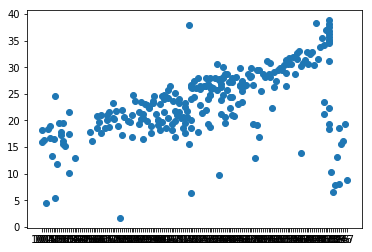

In [9]:
yhat = lr_set1.predict(X_test)
plt.scatter(y_test, yhat)
# The scatterplot shows that there may be a linear relationship between the target variable and the chosen subset.

### 3. Try 70/30 and 90/10 train/test splits (70% of the data for training - 30% for testing, then 90% for training - 10% for testing)
Score and plot. How do your metrics change? What does this tell us about the size of training/testing splits?

In [10]:
predictors_set2 = ['CRIM', 'NOX', 'RM', 'LSTAT']

X_train, X_test, y_train, y_test = train_test_split(X[predictors_set2], y, train_size=0.7, random_state=1)

lr_set2 = LinearRegression()
lr_set2.fit(X_train, y_train)
lr_set2.score(X_test, y_test)

/Users/matthewloh60/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0.6925320135006313

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X[predictors_set1], y, train_size=0.9, random_state=1)

lr_set1 = LinearRegression()
lr_set1.fit(X_train, y_train)
lr_set1.score(X_test, y_test)

/Users/matthewloh60/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0.6925440940568994

The scores represent R^2 values and they are similar for difference spilits. This implies that the model generated has high bias but low variance. 

### 4. Use k-fold cross validation varying the number of folds from 5 to 10
What seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your score. What are the tradeoffs associated with choosing the number of folds?

In [12]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

# iterate through folds 5-10
for folds in range(5,11):
    print('------------------------------------\n')
    print('K: {}'.format(folds))
    lr_set1 = LinearRegression()
    
    # Perform cross-validation
    scores = cross_val_score(lr_set1, X[predictors_set1], y, cv=folds)
    print("Cross-validated scores: {}".format(scores))
    print("Mean CV R2: {}".format(np.mean(scores)))
    print('Std CV R2: {}'.format(np.std(scores)))
    
    # Make cross-validated predictions
    predictions = cross_val_predict(lr_set1, X[predictors_set1], y, cv=folds)
    
    r2 = metrics.r2_score(y, predictions)
    print("Cross-Predicted R2: {}".format(r2))

------------------------------------

K: 5
Cross-validated scores: [ 0.64058677  0.69103804  0.41783595  0.14699104 -0.4548653 ]
Mean CV R2: 0.2883173023442282
Std CV R2: 0.4184127972509058
Cross-Predicted R2: 0.5252505565004872
------------------------------------

K: 6
Cross-validated scores: [ 0.5988838   0.68086234  0.47858638  0.59701535 -0.57338101 -0.37097568]
Mean CV R2: 0.23516519675563066
Std CV R2: 0.5069977507258083
Cross-Predicted R2: 0.40533928235754724
------------------------------------

K: 7
Cross-validated scores: [ 0.65289299  0.57268449  0.51802042  0.46060748  0.24607985 -0.86657669
 -0.1715802 ]
Mean CV R2: 0.20173261901457976
Std CV R2: 0.5057976789099542
Cross-Predicted R2: 0.3701067558095513
------------------------------------

K: 8
Cross-validated scores: [ 0.67190871  0.59965156  0.66563198  0.57868929  0.56384507 -0.2955534
 -1.16292438 -0.17436801]
Mean CV R2: 0.18086010500196065
Std CV R2: 0.6240370496592681
Cross-Predicted R2: 0.5604574988725364
-------

The R^2 of the cross validated models get smaller as the number of folds increases, implying that the model is getting less accurate; standard deviation also increased accordingly.

By having a greater number of folds, the training set gets larger and this increases the risk of overfitting. 

# KNN Practice

In [13]:
# Read the iris data into a DataFrame
col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris = pd.read_csv("/Users/matthewloh60/Desktop/unit-3_project/data/iris.data.csv", header=None, names=col_names)
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

# Increase the default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 14

In [15]:
# Create a custom colormap
from matplotlib.colors import ListedColormap

cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

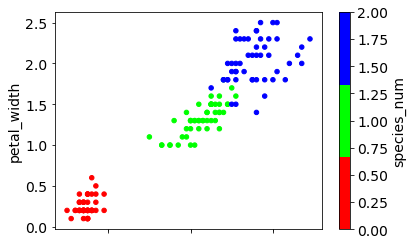

In [16]:
iris['species_num'] = iris.species.map({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2})

iris.plot(kind='scatter', x='petal_length', y='petal_width', c='species_num', colormap=cmap_bold);

# Create a scatterplot of PETAL LENGTH versus PETAL WIDTH and color by SPECIES

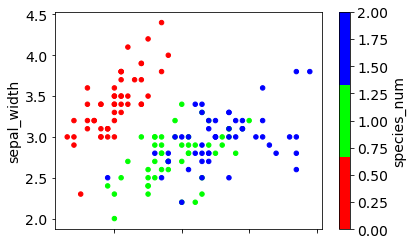

In [17]:
# Create a scatterplot of SEPAL LENGTH versus SEPAL WIDTH and color by SPECIES

iris.plot(kind='scatter', x='sepal_length', y='sepal_width', c='species_num', colormap=cmap_bold);

## KNN Classification of the Iris Dataset

### Create your feature matrix "X"
This will be all species measurements (sepal length, petal width, etc...)

In [18]:
feature_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
X = iris[feature_cols]

### Create your target vector "y"
This will be the species type.

In [19]:
y = iris.species_num

### Make Use of Train-Test-Split
Split your data in to train and test sets.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1)

/Users/matthewloh60/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [21]:
X_train.shape # Quick verification of the splitting of data

(105, 4)

In [22]:
X_test.shape # Quick verification of the splitting of data

(45, 4)

### Import KNN From `scikit-learn` and Instatiate a Model With One Neighbor

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

### Check the Accuracy
Train your model using the training set then use the test set to determine the accuracy

In [24]:
y_pred_class = knn.predict(X_test)
print((metrics.accuracy_score(y_test, y_pred_class))) # Model accuracy seems to good to be true

0.9777777777777777


### Create a Model With Five Neighbors. Did it Improve?

In [25]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred_class = knn.predict(X_test)
print((metrics.accuracy_score(y_test, y_pred_class)))

#Model accuracy did not improve surprisingly. 

0.9777777777777777


### Create a Looped Function That Will Check All Levels of Various Neighbors and Calculate the Accuracy

In [26]:
scores = []
for k in range(1,106): # I set max k to 105 because there are 105 instances in the training set.
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X,y)
    pred = knn.predict(X)
    score = float(sum(pred == y)) / len(y)
    scores.append([k, score])
    
print(scores)

[[1, 1.0], [2, 0.98], [3, 0.96], [4, 0.96], [5, 0.9666666666666667], [6, 0.9733333333333334], [7, 0.9733333333333334], [8, 0.98], [9, 0.98], [10, 0.98], [11, 0.9733333333333334], [12, 0.98], [13, 0.98], [14, 0.98], [15, 0.9866666666666667], [16, 0.9866666666666667], [17, 0.98], [18, 0.9733333333333334], [19, 0.98], [20, 0.98], [21, 0.98], [22, 0.98], [23, 0.98], [24, 0.9733333333333334], [25, 0.98], [26, 0.9733333333333334], [27, 0.9733333333333334], [28, 0.9666666666666667], [29, 0.9733333333333334], [30, 0.9533333333333334], [31, 0.96], [32, 0.9533333333333334], [33, 0.96], [34, 0.96], [35, 0.96], [36, 0.9533333333333334], [37, 0.96], [38, 0.9466666666666667], [39, 0.9533333333333334], [40, 0.9533333333333334], [41, 0.9533333333333334], [42, 0.9533333333333334], [43, 0.9466666666666667], [44, 0.9533333333333334], [45, 0.9466666666666667], [46, 0.9466666666666667], [47, 0.9533333333333334], [48, 0.9466666666666667], [49, 0.96], [50, 0.94], [51, 0.9533333333333334], [52, 0.933333333333

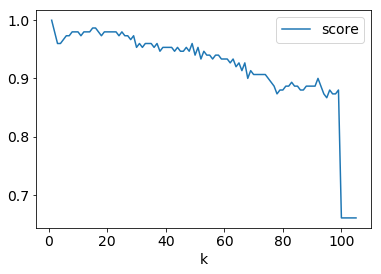

In [27]:
data = pd.DataFrame(scores,columns=['k','score'])
data.plot.line(x='k',y='score');

### Bonus: According to `scikit-learn` Documentation, What is `knn.predict_proba(X_new)` Going to Do?

## Enrichment
_Everything beyond this point is enrichment and examples using Statsmodels for linear regression._

### Example: Using the Statsmodels Formula

Adapt the formula example using your metrics. We will review this implementation in class. Here is a reference to consider. The workflow is the same, but the syntax is a little different. We want to get accustomed to the formula syntax because we will be using them a lot more with regressions. The results should be comparable to scikit-learn's regression models.

In [28]:
# First, format our data in a DataFrame

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

AttributeError: 'DataFrame' object has no attribute 'data'

In [ ]:
# Set up our new statsmodel.formula handling model
import statsmodels.formula.api as smf

# You can easily swap these out to test multiple versions/different formulas
formulas = {
    "case1": "MEDV ~ RM + LSTAT + RAD + TAX + NOX + INDUS + CRIM + ZN - 1", # - 1 = remove intercept
    "case2": "MEDV ~ NOX + RM",
    "case3": "MEDV ~ RAD + TAX"
}

model = smf.ols(formula=formulas['case1'], data=df)
result = model.fit()

result.summary()

### Bonus Challenge #1:

Can you optimize your R2, selecting the best features and using either test-train split or k-folds?

### Bonus Challenge #2:

Given a combination of predictors, can you find another response variable that can be accurately predicted through the exploration of different predictors in this data set?

_Tip: Check out pairplots, coefficients, and Pearson scores._

In [ ]:
# Check out variable relations
import seaborn as sns

sns.pairplot(X);

In [ ]:
# Check out Pearson scores


## Demo: Patsy

In [ ]:
import patsy

# Add response to the core DataFrame
df['MEDV'] = y

In [ ]:
from sklearn.model_selection import train_test_split #If you didn't import it earlier, do so now

# Easily change your variable predictors without reslicing your DataFrame
y, X = patsy.dmatrices("MEDV ~ AGE + RM", data=df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7)


In [ ]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

# Rerun your model, iteratively changing your variables and train_size from the previous cell

lm = LinearRegression()
model = lm.fit(X_train, y_train)

predictions = model.predict(X_test)
print("R^2 Score: {}".format(metrics.r2_score(y_test, predictions)))